<a href="https://colab.research.google.com/github/likitha888/python/blob/main/Implementing_Sensor_Models_for_Range_and_Vision_using_OpenCV%2C_NumPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

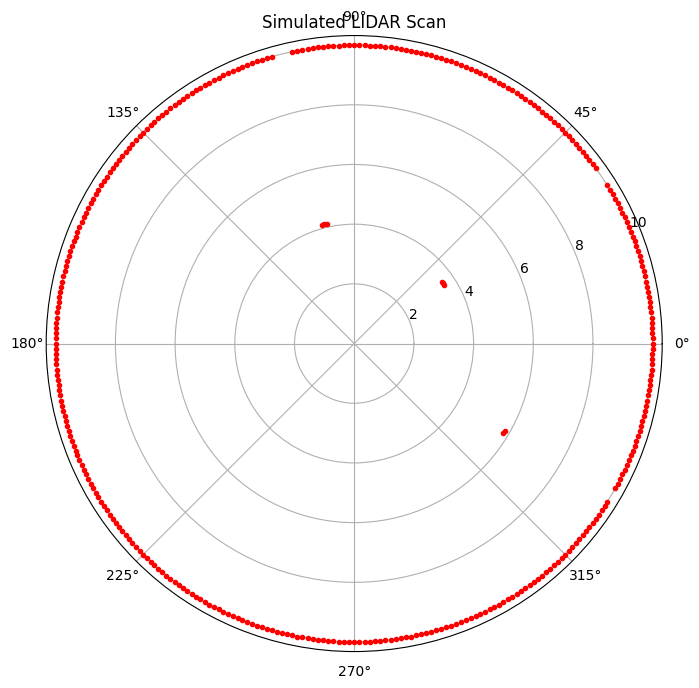

In [1]:
#(lidar_simulation.py)
import numpy as np
import matplotlib.pyplot as plt

def simulate_lidar(robot_pos, obstacles, num_rays=360, max_range=10.0, obstacle_threshold=0.1):
    angles = np.linspace(0, 2*np.pi, num_rays, endpoint=False)
    ranges = np.ones(num_rays) * max_range

    for i, angle in enumerate(angles):
        ray_dir = np.array([np.cos(angle), np.sin(angle)])

        for obs in obstacles:
            # Vector from robot to obstacle
            v = obs - robot_pos

            # Projection of v onto ray direction
            projection = np.dot(v, ray_dir)

            # If projection is negative, obstacle is behind the robot
            if projection <= 0:
                continue

            # Calculate closest point on ray to obstacle
            closest_point = robot_pos + projection * ray_dir
            dist_to_ray = np.linalg.norm(closest_point - obs)

            # If within threshold distance of the ray
            if dist_to_ray < obstacle_threshold:
                dist = np.linalg.norm(v)
                if dist < ranges[i]:
                    ranges[i] = dist

    return angles, ranges

# Example usage
robot_pos = np.array([0.0, 0.0])  # Ensure float type
obstacles = [np.array([3.0, 2.0]), np.array([-1.0, 4.0]), np.array([5.0, -3.0])]

angles, ranges = simulate_lidar(robot_pos, obstacles)

# Plotting
plt.figure(figsize=(8, 8))
plt.polar(angles, ranges, 'r.')
plt.title("Simulated LIDAR Scan")
plt.show()



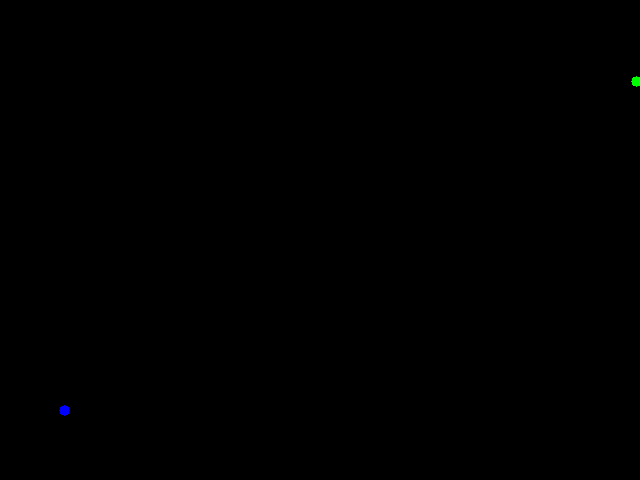

In [2]:
#Simulate a Camera Vision Sensor
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Colab-compatible display function

def simulate_camera(robot_pos, objects, fov=60, img_size=(640, 480)):
    """
    Simulate a camera view from a robot position projecting 3D objects to 2D.

    Args:
        robot_pos (np.ndarray): [x, y, z] camera position in world coordinates.
        objects (list of dicts): List of objects with "pos" (np.ndarray) and "color" (BGR tuple).
        fov (float): Horizontal field of view in degrees.
        img_size (tuple): (width, height) of the output image.

    Returns:
        img (np.ndarray): Simulated camera view (BGR format).
    """
    img = np.zeros((img_size[1], img_size[0], 3), dtype=np.uint8)
    focal_length = img_size[0] / (2 * np.tan(np.radians(fov / 2)))

    for obj in objects:
        # Calculate relative position (ensure z > 0 to avoid division issues)
        rel_pos = obj["pos"] - robot_pos
        x, y, z = rel_pos

        # Skip objects behind the camera (z <= 0)
        if z <= 0:
            continue

        # Perspective projection
        u = int((x * focal_length / z) + img_size[0] // 2)
        v = int((-y * focal_length / z) + img_size[1] // 2)  # Negative y to flip image coordinates

        # Draw if within image bounds
        if 0 <= u < img_size[0] and 0 <= v < img_size[1]:
            cv2.circle(img, (u, v), 5, obj["color"], -1)

    return img

# Example usage
robot_pos = np.array([0.0, 0.0, 1.5])  # Camera at (0, 0, 1.5)
objects = [
    {"pos": np.array([2.0, 1.0, 5.0]), "color": (0, 255, 0)},   # Green object
    {"pos": np.array([-3.0, -2.0, 8.0]), "color": (255, 0, 0)},  # Red object
    {"pos": np.array([1.0, 0.5, -2.0]), "color": (0, 0, 255)},   # Blue object (behind camera)
]

img = simulate_camera(robot_pos, objects)

# Display in Colab
cv2_imshow(img)  # Colab-compatible alternative to cv2.imshow()



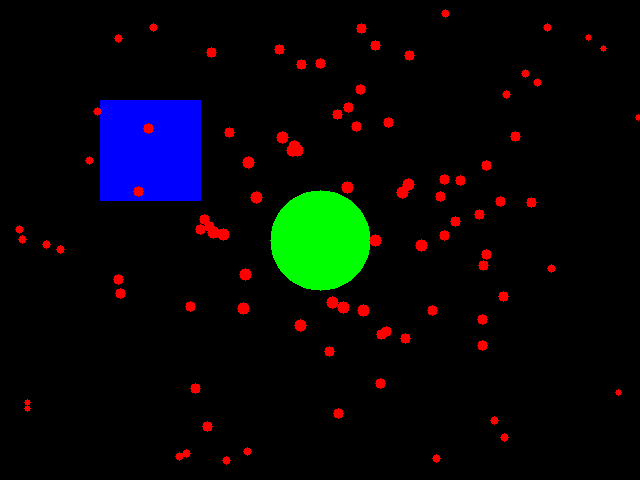

In [3]:
#Sensor Fusion (Optional)
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Colab-compatible display

def fuse_sensors(lidar_ranges, camera_img, fov=60, threshold=5.0):
    """
    Fuse LIDAR range data with camera imagery by overlaying close-range detections.

    Args:
        lidar_ranges (np.ndarray): Array of LIDAR distance measurements
        camera_img (np.ndarray): Camera image (BGR format)
        fov (float): Camera's horizontal field of view in degrees (default 60)
        threshold (float): Maximum distance to visualize (default 5.0 meters)

    Returns:
        np.ndarray: Fused image with LIDAR visualization overlay
    """
    img = camera_img.copy()
    height, width = img.shape[:2]

    # Create angles array matching the LIDAR ranges
    angles = np.linspace(0, 2*np.pi, len(lidar_ranges), endpoint=False)

    # Calculate focal length for proper perspective scaling
    focal_length = width / (2 * np.tan(np.radians(fov/2)))

    for angle, dist in zip(angles, lidar_ranges):
        if dist < threshold:
            # Convert polar to Cartesian (world coordinates)
            x = dist * np.cos(angle)
            y = dist * np.sin(angle)

            # Project to image coordinates (with perspective)
            u = int((x * focal_length / threshold) + width // 2)
            v = int((-y * focal_length / threshold) + height // 2)  # Flip y-axis

            # Draw if within image bounds
            if 0 <= u < width and 0 <= v < height:
                # Make closer objects appear larger
                size = int(5 * (1 - dist/threshold) + 2)
                cv2.circle(img, (u, v), size, (0, 0, 255), -1)  # Red dot

    return img

# Generate test image
img = np.zeros((480, 640, 3), dtype=np.uint8)  # Black background
cv2.circle(img, (320, 240), 50, (0, 255, 0), -1)  # Green circle (center)
cv2.rectangle(img, (100, 100), (200, 200), (255, 0, 0), -1)  # Blue rectangle

# Simulate LIDAR data (360-degree scan)
ranges = np.random.uniform(0.5, 10.0, 360)  # Random distances 0.5-10 meters
ranges[::30] = np.linspace(0.5, 4.5, 12)  # Add some pattern

# Fuse and display
fused_img = fuse_sensors(ranges, img)
cv2_imshow(fused_img)  # Colab-compatible display

